In [3]:
import pandas as pd
import os
import re

def process_parquet(filename, working_dir, db_values=[5, 10, 15, 7]):
    """
    Process a Parquet file, aggregate power by deadband (°F), and
    return a dict of Series like {'DB_15_120': <Series>, ...}.
    """
    file_path = os.path.join(working_dir, filename)
    df = pd.read_parquet(file_path)

    # Ensure datetime is rounded
    df['Time'] = df['Time'].dt.round('min')

    # Convert Celsius → Fahrenheit
    df['DB_F'] = df['Deadband_C'] * 9 / 5
    df = df.drop(columns=['Deadband_C'])


    results = {}

    # Extract the numeric part from "Shed120" for suffix
    match = re.search(r"ShedLong(\d+)", filename)
    suffix = match.group(1) if match else "122"

    for db in db_values:
        df_db = df[df['DB_F'] == db]
        if df_db.empty:
            # print(f"⚠️ No data found for {db}°F in {filename}")
            continue

        # print(df_db.columns)    

        power_sum = df_db.groupby('Time')['Water Heating Electric Power (kW)'].sum()
        # power_sum = df_db.groupby('Time')['Total Electric Power (kW)'].sum()
        upDB = df_db.groupby('Time')['Water Heating Deadband Upper Limit (C)'].mean()
        key = f"DB_{int(db)}_{suffix}"
        results[key] = power_sum
        # results[key] = {
        #     "power": power_sum,
        #     "upDB": upDB
        # }
    return results


def process_parquet_baseline(filename, working_dir):
    """
    Process a Parquet file that does NOT contain a Deadband_C column.
    Simply groups electric power by rounded timestamp.
    Returns: {'DB_ALL_<suffix>': <Series>}
    """
    file_path = os.path.join(working_dir, filename)
    df = pd.read_parquet(file_path)

    

    if "ReserveCanceled" in filename:
        suffix = "Canceled"
    elif "Reserve" in filename:
        match = re.search(r"Reserve(\d+)", filename)
        suffix = match.group(1) if match else "Reserve"
    elif "Normal" in filename:
        match = re.search(r"Normal(\d+)", filename)
        suffix = match.group(1) if match else "Normal"
    elif "Efficiency" in filename:
        match = re.search(r"Efficiency(\d+)", filename)
        suffix = match.group(1) if match else "Efficiency"
    else:
        suffix = "Baseline"

    # Group by Time → sum power
    power_sum = df.groupby('Time')['Water Heating Electric Power (kW)'].sum()
    # power_sum = df.groupby('Time')['Total Electric Power (kW)'].sum()

    # Return in same style as original function
    baseName = os.path.splitext(filename)[0] 
    key = f"{baseName}"

    return {key: power_sum}



def process_Load(filename, working_dir, db_values=[1, 2, 3, 4, 5]):

    file_path = os.path.join(working_dir, filename)
    df = pd.read_parquet(file_path)

    # # Print all columns (debug)
    # for col in df.columns:
    #     print(col)



    # Round timestamp
    df['Time'] = df['Time'].dt.round('min')

    # Convert Celsius → Fahrenheit
    df['DB_F'] = (df['Deadband_C'] * 9 / 5).round(1)
    # print(df['DB_F'])
    df = df.drop(columns=['Deadband_C'])

    results = {}

    # --- Extract Load type ---
    parts = re.split(r'[_\.]', filename)
    load_type = parts[3] if len(parts) > 3 else "Load"

    for db in db_values:
        df_db = df[df['DB_F'] == db]
        if df_db.empty:
            continue

        # ---- Power ----
        power_sum = (
            df_db
            .groupby('Time')['Water Heating Electric Power (kW)']
            .sum()
        )

        results[f"DB_{int(db)}_{load_type}"] = power_sum

        # ---- Control temperature (time series) ----
        control_temp_ts = (
            df_db
            .groupby('Time')["Water Heating Control Temperature (C)"]
            .mean()
        )

        # results[f"DB_{int(db)}_Control_Temp"] = control_temp_ts

    return results



print('done')

# def process_parquet(filename, working_dir, db_values=[5, 10, 15, 7]):
#     """
#     Process a Parquet file, aggregate power by deadband (°F), and
#     return a dict of Series like {'DB_15_122': <Series>, ...}.
#     """
#     import os, re
#     import pandas as pd

#     file_path = os.path.join(working_dir, filename)
#     df = pd.read_parquet(file_path)

#     # Round timestamp
#     df['Time'] = df['Time'].dt.round('min')

#     # Use the existing column in your files
#     df['DB_F'] = df['Shed Deadband (F)']

#     results = {}

#     # Extract numeric part for suffix
#     match = re.search(r"122", filename)  # or adjust regex if your filenames vary
#     suffix = match.group(0) if match else "122"

#     for db in db_values:
#         df_db = df[df['DB_F'] == db]
#         if df_db.empty:
#             continue

#         power_sum = df_db.groupby('Time')['Water Heating Electric Power (kW)'].sum()
#         key = f"DB_{int(db)}_{suffix}"
#         results[key] = power_sum

#     return results


done


In [101]:
WORKING_DIR = r"C:\Users\danap\OCHRE_Working"

files = [
    # "180110_1_3_ShedLong110_Control.parquet",
    # "180110_1_3_ShedLong115_Control.parquet",
    # "180110_1_3_ShedLong120_Control.parquet",
    # "180110_1_3_ShedLong125_Control.parquet",
    # "180110_1_3_ShedLong105_Control.parquet",
    # "180110_1_3_ShedLong100_Control.parquet",
    # "180110_1_3_ShedLong95_Control.parquet",
    # "180110_1_3_ShedLong122_Control.parquet",
    # "180110_1_3_ShedLong118_Control.parquet",
    # "180113_1_3_EnergyShed122_Control.parquet",
    # "180113_1_3_ReserveCanceled_Control.parquet",
    # "180113_1_3_Reserve91_Control.parquet"
    # "180113_1_3_Reserve20_Control.parquet",
    # "180113_1_3_EfficiencyTest0C_Control.parquet",
    # "180113_1_3_EfficiencyTest1C_Control.parquet",
    # "180113_1_3_EfficiencyTest2C_Control.parquet",
    # "180113_1_3_EfficiencyTest3C_Control.parquet",
    "180113_1_3_EfficiencyControl0C_Control.parquet",
    "180113_1_3_EfficiencyControl1C_Control.parquet",
    "180113_1_3_EfficiencyControl2C_Control.parquet",
    "180113_1_3_EfficiencyControl3C_Control.parquet",
    "180113_1_3_EfficiencyControl3C2_Control.parquet",
    "180113_1_3_EfficiencyControl4C_Control.parquet",
    # "180113_1_3_EfficiencyControl9C_Control.parquet",
    # "180113_1_3_EnergyShed_125_Control_DB15.parquet"
    
]


all_results = {}
for f in files:
    res = process_parquet_baseline(f, WORKING_DIR)
    all_results.update(res)

# res = process_parquet_baseline("180113_1_3_BaselineLoad_Control.parquet", WORKING_DIR)
# res = process_parquet_baseline("180110_1_3_Normal130_Baseline.parquet", WORKING_DIR)

all_results.update(res)

# print(all_results["DB_15_120"].head())


# # all_results = {}
# for f in files:
#     res = process_parquet(f, WORKING_DIR)
#     all_results.update(res)

# filesLoad = [
#     "180110_1_3_AdvLoad_Control.parquet",
#     "180110_1_3_Load_Control.parquet",

# ]

# for f in filesLoad:
#     res = process_Load(f, WORKING_DIR)
#     all_results.update(res)

print(all_results.keys())


dict_keys(['180113_1_3_EfficiencyControl0C_Control', '180113_1_3_EfficiencyControl1C_Control', '180113_1_3_EfficiencyControl2C_Control', '180113_1_3_EfficiencyControl3C_Control', '180113_1_3_EfficiencyControl3C2_Control', '180113_1_3_EfficiencyControl4C_Control'])


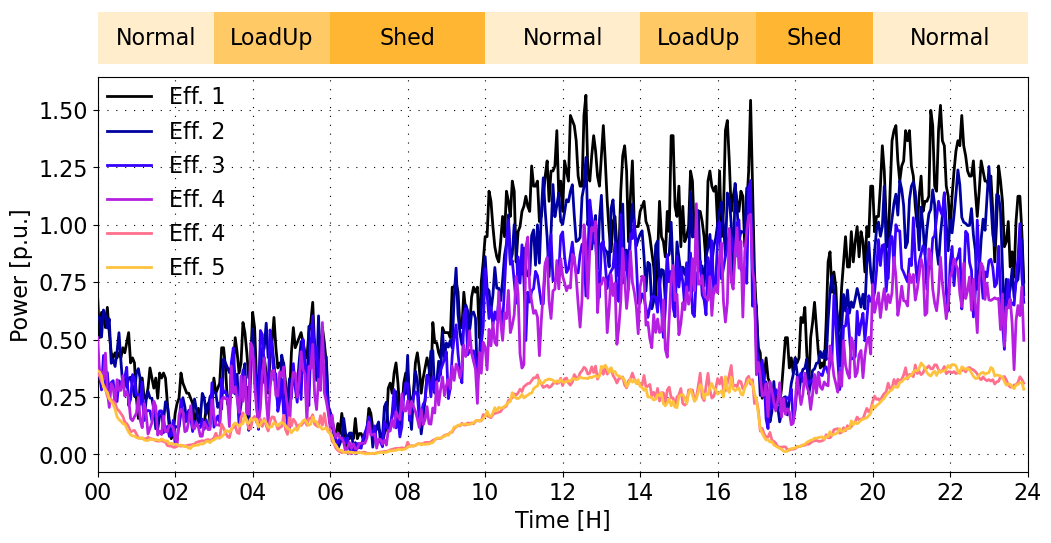

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors




A = 16
prated = 0.5
n = 409
N = n * prated

keys_to_plot = [key for key in all_results]
#keys_to_plot = ['180113_1_3_EfficiencyTest1C_Control', '180113_1_3_EfficiencyTest2C_Control', '180113_1_3_EfficiencyTest3C_Control', '180113_1_3_BaselineLoad_Control']
# -------------------------------
# Example bars subplot data
# -------------------------------
# results = {'': [24]} # , 4, 3, 3, 4
# words = ['Normal'] # , 'Normal', 'LoadUp', 'Shed', 'Normal'
results = {'': [3, 3, 4, 4, 3, 3, 4]}
words = ['Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp','Shed','Normal']


def short_label(key):
    parts = key.split("_")
    if "AdvLoad" in key:
        return f"ALU_{parts[1]}"   # Advanced Load Up -> ALU_1, ALU_2
    elif "Load" in key:
        return f"LU_{parts[1]}"    # Load Up -> LU_1, LU_2
    elif "Baseline" in key:
        return "Baseline"
    else:
        return key


def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    alpha_map = {
        'Normal': 0.2,
        'LoadUp': 0.6,
        'Shed': 0.8,
        'Grid Emergency': 1,
        'Reserve': 1,
        'ALU': 1
    }
    
    # Automatically create the Alpha list
    Alpha = [alpha_map[word] for word in words]
    
    text_color = ['black'] * len(category_names)

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, color='orange', edgecolor='none', alpha=Alpha[i])
        for j, rect in enumerate(rects):
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_y() + rect.get_height()/2,
                    category_names[i],
                    ha='center', va='center', color=text_color[i], fontsize=A)


# -------------------------------
# Select deadbands to plot
# -------------------------------
# Pick any 1–2 keys from all_results
DB_list = [all_results[k] for k in keys_to_plot]
# DB_upLIST = DB_list = [all_results[k]["upDB"] for k in keys_to_plot]

labels = [f"{k}" for k in keys_to_plot]  # or f"DB {db}°F"

cmap = plt.colormaps['gnuplot2']  # this is the colormap object
# colors = [cmap(i / len(keys_to_plot)) for i in range(len(keys_to_plot))]
colors = ['black']

# -------------------------------
# Create figure and axes
# -------------------------------
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1, figsize=(12, 6), 
    gridspec_kw={'height_ratios':[1, 7]}, 
    sharex=False
)



fig.subplots_adjust(hspace=0.05)
# Horizontal bars (example)
bars(ax_bars, results, words)

# -------------------------------
# Plot deadband curves
# -------------------------------

# Only fill where baseline < shed

# hours = (DB_list[0].index - DB_list[0].index[0]).total_seconds() / 3600
# ax_control.fill_between(
#     hours,
#     DB_list[0].values / N,
#     DB_list[1].values / N,
#     where=(DB_list[0].values / N < DB_list[1].values / N),
#     alpha=1,
#     linewidth=0,
#     color='plum'
# )

# ax_control.fill_between(
#     hours,
#     DB_list[0].values / N,
#     DB_list[1].values / N,
#     where=(DB_list[0].values / N > DB_list[1].values / N),
#     alpha=1,
#     linewidth=0,
#     color='lightgreen'
# )

cmap = plt.colormaps['gnuplot2']

# # Only use the middle 80% of the colormap
cmap_trunc = mcolors.LinearSegmentedColormap.from_list(
    'cool_trunc',
    cmap(np.linspace(0, 0.7, 256))
)

colors = [cmap_trunc(i / (len(keys_to_plot) - 1))
          for i in range(len(keys_to_plot))]


# cmap_trunc = mcolors.LinearSegmentedColormap.from_list(
#     'cool_trunc',
#     cmap(np.linspace(0, 0.7, 256))
# )


for i, db_series in enumerate(DB_list):

    key = keys_to_plot[i]
    label = short_label(key)
    parts = key.split("_")
    mid = parts[1]        # e.g. "5", "10", "Baseline"

    if db_series.empty:
        print(f"{key} is empty")
        continue

    db_series = db_series.iloc[:479] # 479

    # Ensure index is datetime
    if not np.issubdtype(db_series.index.dtype, np.datetime64):
        db_series.index = pd.to_datetime(db_series.index)

    # Convert datetime to numeric hours
    hours = (db_series.index - db_series.index[0]).total_seconds() / 3600


    cmap_trunc = mcolors.LinearSegmentedColormap.from_list(
        'cool_trunc',
        cmap(np.linspace(0, 0.8, 256)) # 0, 0.7, 256
    )
    
    colors = [cmap_trunc(i / (len(keys_to_plot) - 1))
              for i in range(len(keys_to_plot))]

    lw = [4, 4, 4]
    lab = ['Baseline', 'Reserve', 'Canceled']
    lab = [1, 2, 3, 4, 4, 5, 9]

    # ---------------------------------------
    # SPECIAL CASE: baseline curve formatting
    # ---------------------------------------
    
    if mid == "Baseline":
        ax_control.plot(
            hours,
            db_series.values/N,
            # # color='darkorchid',
            # color = 'gold',
            color = col[i],
            linewidth=lw[i],      # maybe thicker?
            linestyle="-",     # dashed line
            label=lab[i],
            zorder=5
        )
        continue

    # ---------------------------------------
    # Normal DB curves
    # ---------------------------------------
    ax_control.plot(
        hours,
        db_series.values/N,
        # color=colors[i],
        color=colors[i],
        linewidth=2,
        label=f'Eff. {lab[i]}',
        zorder = 10
        # label=leg[i]
    )




ax_control.set_ylabel("Power [p.u.]", fontsize=A)
ax_control.set_xlabel("Time [H]", fontsize=A)
ax_control.tick_params(axis='x', labelrotation=0, labelsize=A)
ax_control.tick_params(axis='y', labelsize=A)


# X-axis formatting
ax_control.set_xlim(0, 24)
ax_control.set_xticks(range(0, 25, 2))
ax_control.set_xticklabels([f"{h:02d}" for h in range(0, 25, 2)])

# ax_control.set_ylim(0, 0.35)
# ax_control.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])


ax_control.grid(True, linestyle=(0, (1, 7)), color='black', linewidth=0.8)
# ax_control.legend(fontsize=A)
ax_control.legend(
    fontsize=A,
    loc="upper left",        # anchor the legend at the upper left of the bbox
    # bbox_to_anchor=(0, 0),  # move the legend outside, just to the right
    borderaxespad=0,          # remove padding between axes and legend
    frameon=False
)


RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
filename = '180113_1_3_EfficiencyEnergy.pdf'
filepath = os.path.join(RESULTS_DIR, filename)
# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)
# plt.tight_layout()
plt.show()



In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# -------------------------------
# Constants
# -------------------------------
A = 16
prated = 0.5
n = 409
N = n * prated

# -------------------------------
# Example bars subplot data
# -------------------------------
results = {'': [6, 18]}
words = ['Grid Emerg.', 'Normal']

# -------------------------------
# Styling map for curves
# -------------------------------
STYLE_MAP = {
    "Baseline": {
        "color": "gold",
        "linewidth": 10,
        "label": "Baseline",
        "zorder": 1,
    },
    "Reserve": {
        "color": "green",
        "linewidth": 4,
        "label": "Blackstart Support",
        "zorder": 10,
    },
    "Canceled": {
        "color": "darkorchid",
        "linewidth": 3,
        "label": "Reserve Canceled",
        "zorder": 50,
    },
}

# -------------------------------
# Helper functions
# -------------------------------
def short_label(key):
    if "Baseline" in key:
        return "Baseline"
    elif "Canceled" in key:
        return "Reserve Canceled"
    else:
        return "Reserve"


def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    alpha_map = {
        'Normal': 0.2,
        'LoadUp': 0.6,
        'Shed': 0.8,
        'Grid Emerg.': 1,
        'Reserve': 1,
        'ALU':1
    }

    Alpha = [alpha_map[word] for word in words]

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for spine in ax.spines.values():
        spine.set_visible(False)

    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(
            labels,
            widths,
            left=starts,
            color='orange',
            edgecolor='none',
            alpha=Alpha[i]
        )
        for rect in rects:
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                category_names[i],
                ha='center',
                va='center',
                fontsize=A
            )

# -------------------------------
# Select series to plot
# -------------------------------
keys_to_plot = [
'DB_10_122', 'DB_Baseline_130'
]

DB_list = [all_results[k] for k in keys_to_plot]

# -------------------------------
# Create figure
# -------------------------------
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1,
    figsize=(12, 6),
    gridspec_kw={'height_ratios': [1, 7]},
)

fig.subplots_adjust(hspace=0.05)
# -------------------------------
# Bars subplot
# -------------------------------
bars(ax_bars, results, words)

# -------------------------------
# Filled difference (baseline vs reserve)
# -------------------------------
# hours = (DB_list[0].index - DB_list[0].index[0]).total_seconds() / 3600

# ax_control.fill_between(
#     hours,
#     DB_list[0].values / N,
#     DB_list[1].values / N,
#     where=(DB_list[0].values / N < DB_list[1].values / N),
#     color='lightgreen',
#     linewidth=0
# )

# ax_control.fill_between(
#     hours,
#     DB_list[0].values / N,
#     DB_list[1].values / N,
#     where=(DB_list[0].values / N > DB_list[1].values / N),
#     color='plum',
#     linewidth=0
# )

# -------------------------------
# Plot curves
# -------------------------------
for i, db_series in enumerate(DB_list):

    key = keys_to_plot[i]

    if db_series.empty:
        continue

    db_series = db_series.iloc[:479]

    if not np.issubdtype(db_series.index.dtype, np.datetime64):
        db_series.index = pd.to_datetime(db_series.index)

    hours = (db_series.index - db_series.index[0]).total_seconds() / 3600


    if "Canceled" in key:
        curve_type = "Canceled"
    elif key.endswith("_130"):
        curve_type = "Baseline"
    else:
        curve_type = "Reserve"

    style = STYLE_MAP[curve_type]

    ax_control.plot(
        hours,
        db_series.values / N,
        color=style["color"],
        linewidth=style["linewidth"],
        label=style["label"],
        zorder=style["zorder"]
    )

# -------------------------------
# Axis formatting
# -------------------------------
ax_control.set_ylabel("Power [p.u.]", fontsize=A)
ax_control.set_xlabel("Time [H]", fontsize=A)
ax_control.tick_params(axis='both', labelsize=A)

ax_control.set_xlim(0, 24)
ax_control.set_xticks(range(0, 25, 2))
ax_control.set_xticklabels([f"{h:02d}" for h in range(0, 25, 2)])

ax_control.set_ylim(0, 0.5)

ax_control.grid(True, linestyle=(0, (1, 7)), color='black', linewidth=0.8)

ax_control.legend(
    fontsize=A,
    loc="lower right",
    frameon=False
)

# -------------------------------
# Save / show
# -------------------------------
RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
filename = '180110_1_3_Blackstart.pdf'
filepath = os.path.join(RESULTS_DIR, filename)

# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)
# plt.tight_layout()
plt.show()


KeyError: 'DB_10_122'

In [77]:
# -------------------------------
# Select deadbands to plot
# -------------------------------
keys_to_plot = ['DB_1_Load', 'DB_2_Load', 'DB_3_Load', 'DB_4_Load', 'DB_5_Load']
DB_list = [all_results[k] for k in keys_to_plot]

labels = [f"{k}" for k in keys_to_plot]

cmap = plt.colormaps['gnuplot2']
colors = [cmap(i / len(keys_to_plot)) for i in range(len(keys_to_plot))]

# -------------------------------
# Extract baseline series FIRST
# -------------------------------
baseline_key = [k for k in keys_to_plot if "Baseline" in k][0]
baseline_series = all_results[baseline_key].iloc[:479]

# Ensure datetime index
if not np.issubdtype(baseline_series.index.dtype, np.datetime64):
    baseline_series.index = pd.to_datetime(baseline_series.index)

baseline_hours = (baseline_series.index - baseline_series.index[0]).total_seconds() / 3600
baseline_vals = baseline_series.values / N


# -------------------------------
# Create figure and axes
# -------------------------------
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1, figsize=(12, 6), 
    gridspec_kw={'height_ratios':[1, 7]}, 
    sharex=False
)

# Horizontal bars
bars(ax_bars, results, words)

# -------------------------------
# Plot deadband shaded regions
# -------------------------------
hours = (DB_list[0].index - DB_list[0].index[0]).total_seconds() / 3600

# -------------------------------
# Corrected fill_between (length-safe)
# -------------------------------
baseline_vals = DB_list[1].values / N
reserve_vals  = DB_list[0].values / N

min_len = min(len(hours), len(baseline_vals), len(reserve_vals))

hours_use    = hours[:min_len]
baseline_use = baseline_vals[:min_len]
reserve_use  = reserve_vals[:min_len]
total_use    =  reserve_use + baseline_use

# Reserve > 0
# ax_control.fill_between(
#     hours_use,
#     baseline_use,
#     total_use,
#     where=(reserve_use >= 0),
#     alpha=1,
#     linewidth=0,
#     color='lightgreen'
# )

# # Reserve < 0
# ax_control.fill_between(
#     hours_use,
#     baseline_use,
#     total_use,
#     where=(reserve_use < 0),
#     alpha=1,
#     linewidth=0,
#     color='plum'
# )

# -------------------------------
# Plot curves
# -------------------------------
for i, db_series in enumerate(DB_list):

    key = keys_to_plot[i]
    label = short_label(key)
    parts = key.split("_")
    mid = parts[1]

    if db_series.empty:
        print(f"{key} is empty")
        continue

    db_series = db_series.iloc[:479]

    # Ensure datetime index
    if not np.issubdtype(db_series.index.dtype, np.datetime64):
        db_series.index = pd.to_datetime(db_series.index)

    # Convert datetime to numeric hours
    hours = (db_series.index - db_series.index[0]).total_seconds() / 3600

    # -------------------------------
    # BASELINE (purple)
    # -------------------------------
# -------------------------------
# BASELINE (purple) — length-safe
# -------------------------------
    if mid == "Baseline":
    
        min_len = min(len(baseline_hours), len(baseline_vals))
    
        ax_control.plot(
            baseline_hours[:min_len],
            baseline_vals[:min_len],
            color='darkorchid',
            linewidth=3.2,
            linestyle='-',
            label="Baseline",
            zorder=100
        )
        continue


    # -------------------------------
    # RESERVE + BASELINE (green)
    # -------------------------------
    reserve_vals = db_series.values / N
    min_len = min(len(reserve_vals), len(baseline_vals))

    green_sum = reserve_vals[:min_len] + baseline_vals[:min_len]
    hours_use = hours[:min_len]

    ax_control.plot(
        hours_use,
        green_sum,
        color='green',
        linewidth=2.8,
        label="Reserve",
        zorder=10
    )

# -------------------------------
# Formatting
# -------------------------------
ax_control.set_ylabel("Power [p.u.]", fontsize=A)
ax_control.set_xlabel("Time [H]", fontsize=A)
ax_control.tick_params(axis='x', labelrotation=0, labelsize=A)
ax_control.tick_params(axis='y', labelsize=A)

ax_control.set_xlim(0, 24)
ax_control.set_xticks(range(0, 25, 2))
ax_control.set_xticklabels([f"{h:02d}" for h in range(0, 25, 2)])

ax_control.set_ylim(0, 0.4)

ax_control.grid(True, linestyle=(0, (1, 7)), color='black', linewidth=0.8)

ax_control.legend(
    fontsize=A,
    loc="upper right",
    borderaxespad=0,
    frameon=False
)

# -------------------------------
# Save / Show
# -------------------------------
RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
filename = '180113_1_3_EnergyShed_122_7.pdf'
filepath = os.path.join(RESULTS_DIR, filename)
# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)

plt.tight_layout()
plt.show()


IndexError: list index out of range

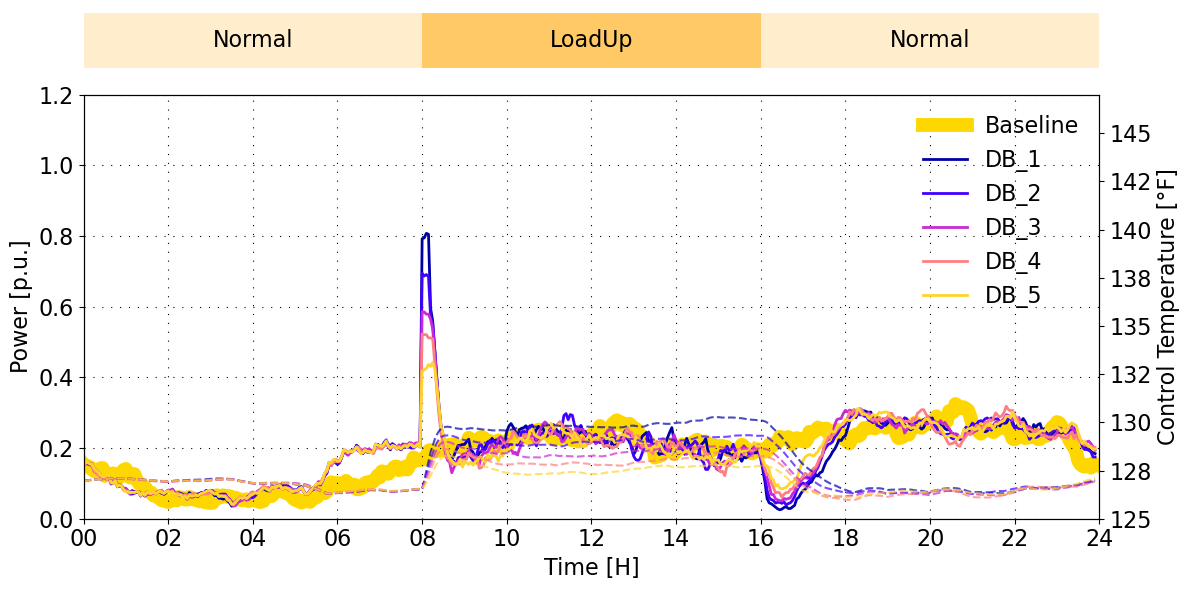

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter

# ======================================================
# Constants
# ======================================================
A = 16
prated = 0.5
n = 409
N = n * prated

# ======================================================
# Example bars subplot data
# ======================================================
results = {'': [8, 8, 8]} # 3, 3, 4, 4, 3, 3, 4
words = ['Normal', 'LoadUp', 'Normal'] # 'Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp', 'Shed', 'Normal'

def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    alpha_map = {
        'Normal': 0.2,
        'LoadUp': 0.6,
        'Shed': 1
    }
    
    # Automatically create the Alpha list
    Alpha = [alpha_map[word] for word in words]
    
    text_color = ['black'] * len(category_names)

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for spine in ax.spines.values():
        spine.set_visible(False)

    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts,
                        color='orange', edgecolor='none', alpha=Alpha[i])
        for rect in rects:
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_y() + rect.get_height()/2,
                    colname,
                    ha='center', va='center',
                    color=text_color[i], fontsize=A)

# ======================================================
# Select deadbands to plot
# ======================================================
keys_to_plot = [
    'DB_Baseline_130',
    # 'DB_1_AdvLoad',
    # 'DB_2_AdvLoad',
    # 'DB_3_AdvLoad',
    # 'DB_4_AdvLoad',
    # 'DB_5_AdvLoad',
    'DB_1_Load',
    'DB_2_Load',
    'DB_3_Load',
    'DB_4_Load',
    'DB_5_Load'
    # 'DB_2_BaselineLoad',
    # 'DB_2_BaselineLoad',
    # 'DB_3_BaselineLoad',
    # 'DB_4_BaselineLoad',
    # 'DB_5_BaselineLoad',
]

DB_list = [all_results[k] for k in keys_to_plot]

# leg = [
#     'Baseline',
#     'LU_DB=1F',
#     'LU_DB=2F',
#     'LU_DB=3F',
#     'LU_DB=4F',
#     'LU_DB=5F'
# ]

cmap = plt.colormaps['gnuplot2']
colors = [cmap(i / len(keys_to_plot)) for i in range(len(keys_to_plot))]

# ======================================================
# Create figure and axes
# ======================================================
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1, figsize=(12, 6),
    gridspec_kw={'height_ratios': [1, 7]},
    sharex=False
)

ax_temp = ax_control.twinx()

# ======================================================
# Bars subplot
# ======================================================
bars(ax_bars, results, words)

# ======================================================
# Plot power + control temperature
# ======================================================

def c2f(t):
    return 9/5 * t + 32
for i, power_series in enumerate(DB_list):

    key = keys_to_plot[i]
    parts = key.split("_")
    mid = parts[1]

    if power_series.empty:
        continue

    power_series = power_series.iloc[:479]

    if not np.issubdtype(power_series.index.dtype, np.datetime64):
        power_series.index = pd.to_datetime(power_series.index)

    hours = (power_series.index - power_series.index[0]).total_seconds() / 3600

    # ---------------- BASELINE ----------------
    if mid == "Baseline":
        ax_control.plot(
            hours,
            power_series.values / N,
            color='gold',
            linewidth=10,
            label='Baseline',
            zorder=0
        )
        continue

    # ---------------- POWER ----------------
    label = mid.replace("AdvLoad", "")  # e.g. "1", "2", "3", ...
    ax_control.plot(
        hours,
        power_series.values / N,
        color=colors[i],
        linewidth=2,
        # label=leg[i]
        label=f'DB_{label}'
    )

    # ---------------- CONTROL TEMPERATURE ----------------
    temp_key = f"DB_{mid}_Control_Temp"

    if temp_key not in all_results:
        continue

    temp_series = all_results[temp_key].iloc[:479]

    if not np.issubdtype(temp_series.index.dtype, np.datetime64):
        temp_series.index = pd.to_datetime(temp_series.index)

    temp_hours = (temp_series.index - temp_series.index[0]).total_seconds() / 3600

    ax_temp.plot(
        temp_hours,
        c2f(temp_series.values),
        color=colors[i],
        linestyle='--',
        linewidth=1.5,
        alpha=0.7
    )

# ======================================================
# Axis formatting
# ======================================================
ax_control.set_ylabel("Power [p.u.]", fontsize=A)
ax_control.set_xlabel("Time [H]", fontsize=A)
ax_control.tick_params(axis='x', labelsize=A)
ax_control.tick_params(axis='y', labelsize=A)

ax_control.set_xlim(0, 24)
ax_control.set_xticks(range(0, 25, 2))
ax_control.set_xticklabels([f"{h:02d}" for h in range(0, 25, 2)])

ax_control.set_ylim(0, 1.2)
ax_control.grid(True, linestyle=(0, (1, 7)), color='black', linewidth=0.8)

ax_temp.set_ylabel("Control Temperature [°F]", fontsize=A)
ax_temp.tick_params(axis='y', labelsize=A)
ax_temp.set_ylim(125, 147)   # adjust if needed
ax_temp.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x:.0f}")
)

ax_control.legend(
    fontsize=A,
    loc="upper right",
    frameon=False
)

# ======================================================
# Save / show
# ======================================================
RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
filename = '180110_1_3_AdvLoadUp_DB.pdf'
filepath = os.path.join(RESULTS_DIR, filename)

# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)
plt.tight_layout()
plt.show()


# plot no temp for load up 

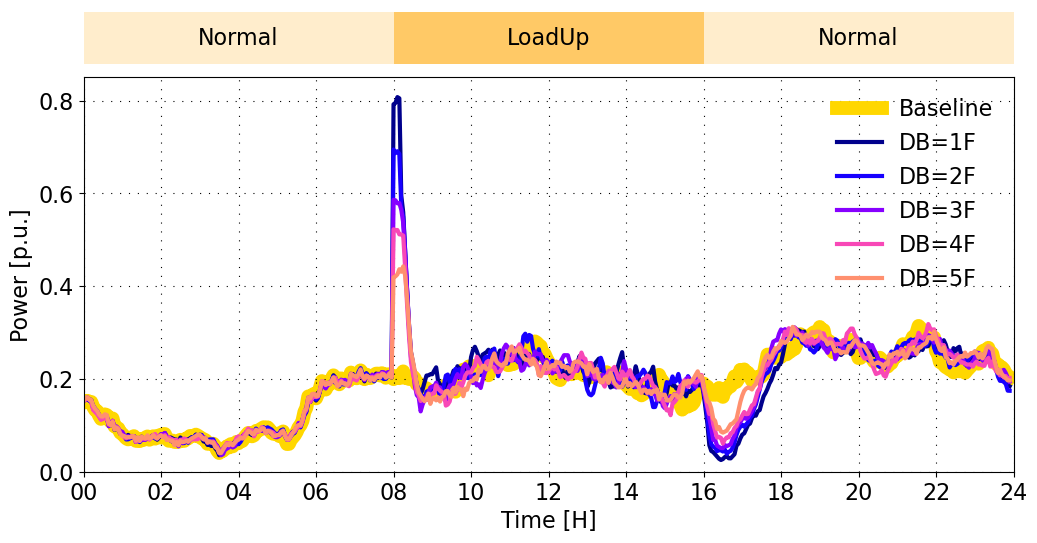

In [117]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

# ======================================================
# Constants
# ======================================================
A = 16
prated = 0.5
n = 409
N = n * prated

# ======================================================
# Example bars subplot data
# ======================================================
results = {'': [8, 8, 8]} # 3, 3, 4, 4, 3, 3, 4
words = ['Normal', 'LoadUp', 'Normal'] # 'Normal', 'LoadUp', 'Shed', 'Normal', 'LoadUp', 'Shed', 'Normal'

def bars(ax, results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    alpha_map = {
        'Normal': 0.2,
        'LoadUp': 0.6,
        'Advanced LoadUp': 0.6,
        'Shed': 1
    }
    
    # Automatically create the Alpha list
    Alpha = [alpha_map[word] for word in words]
    
    text_color = ['black'] * len(category_names)

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for spine in ax.spines.values():
        spine.set_visible(False)

    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts,
                        color='orange', edgecolor='none', alpha=Alpha[i])
        for rect in rects:
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_y() + rect.get_height()/2,
                    colname,
                    ha='center', va='center',
                    color=text_color[i], fontsize=A)

# ======================================================
# Select deadbands to plot
# ======================================================
keys_to_plot = [
    'DB_Baseline_130',
    # 'DB_1_AdvLoad',
    # 'DB_2_AdvLoad',
    # 'DB_3_AdvLoad',
    # 'DB_4_AdvLoad',
    # 'DB_5_AdvLoad',
    'DB_1_Load',
    'DB_2_Load',
    'DB_3_Load',
    'DB_4_Load',
    'DB_5_Load'
    # 'DB_2_BaselineLoad',
    # 'DB_2_BaselineLoad',
    # 'DB_3_BaselineLoad',
    # 'DB_4_BaselineLoad',
    # 'DB_5_BaselineLoad',
]

DB_list = [all_results[k] for k in keys_to_plot]

# leg = [
#     'Baseline',
#     'LU_DB=1F',
#     'LU_DB=2F',
#     'LU_DB=3F',
#     'LU_DB=4F',
#     'LU_DB=5F'
# ]


cmap = plt.colormaps['gnuplot2']

# Only use the middle 80% of the colormap
cmap_trunc = LinearSegmentedColormap.from_list(
    'cool_trunc',
    cmap(np.linspace(0, 0.7, 256))
)

colors = [cmap_trunc(i / (len(keys_to_plot) - 1))
          for i in range(len(keys_to_plot))]

# cmap = plt.colormaps['cool'] # gnuplot2, cool
# colors = [cmap(i / len(keys_to_plot)) for i in range(len(keys_to_plot))]

# ======================================================
# Create figure and axes
# ======================================================
fig, (ax_bars, ax_control) = plt.subplots(
    2, 1, figsize=(12, 6),
    gridspec_kw={'height_ratios': [1, 7]},
)

fig.subplots_adjust(hspace=0.05)
# ======================================================
# Bars subplot
# ======================================================
bars(ax_bars, results, words)

# ======================================================
# Plot power + control temperature
# ======================================================

def c2f(t):
    return 9/5 * t + 32
for i, power_series in enumerate(DB_list):

    key = keys_to_plot[i]
    parts = key.split("_")
    mid = parts[1]

    if power_series.empty:
        continue

    power_series = power_series.iloc[:479]

    if not np.issubdtype(power_series.index.dtype, np.datetime64):
        power_series.index = pd.to_datetime(power_series.index)

    hours = (power_series.index - power_series.index[0]).total_seconds() / 3600

    # ---------------- BASELINE ----------------
    if mid == "Baseline":
        ax_control.plot(
            hours,
            power_series.values / N,
            color='gold',
            linewidth=10,
            label='Baseline',
            zorder=0
        )
        continue

    # ---------------- POWER ----------------
    label = mid.replace("AdvLoad", "")  # e.g. "1", "2", "3", ...
    ax_control.plot(
        hours,
        power_series.values / N,
        color=colors[i],
        linewidth=3,
        # label=leg[i]
        label=f'DB={label}F'
    )

    # # ---------------- CONTROL TEMPERATURE ----------------
    # temp_key = f"DB_{mid}_Control_Temp"

    # if temp_key not in all_results:
    #     continue

    # temp_series = all_results[temp_key].iloc[:479]

    # if not np.issubdtype(temp_series.index.dtype, np.datetime64):
    #     temp_series.index = pd.to_datetime(temp_series.index)

    # temp_hours = (temp_series.index - temp_series.index[0]).total_seconds() / 3600

    # ax_temp.plot(
    #     temp_hours,
    #     c2f(temp_series.values),
    #     color=colors[i],
    #     linestyle='--',
    #     linewidth=1.5,
    #     alpha=0.7
    # )

# ======================================================
# Axis formatting
# ======================================================
ax_control.set_ylabel("Power [p.u.]", fontsize=A)
ax_control.set_xlabel("Time [H]", fontsize=A)
ax_control.tick_params(axis='x', labelsize=A)
ax_control.tick_params(axis='y', labelsize=A)

ax_control.set_xlim(0, 24)
ax_control.set_xticks(range(0, 25, 2))
ax_control.set_xticklabels([f"{h:02d}" for h in range(0, 25, 2)])

ax_control.set_ylim(0, 0.85)
ax_control.grid(True, linestyle=(0, (1, 7)), color='black', linewidth=0.8)

# ax_temp.set_ylabel("Control Temperature [°F]", fontsize=A)
# ax_temp.tick_params(axis='y', labelsize=A)
# ax_temp.set_ylim(125, 147)   # adjust if needed
# ax_temp.yaxis.set_major_formatter(
#     FuncFormatter(lambda x, _: f"{x:.0f}")
# )

ax_control.legend(
    fontsize=A,
    loc="upper right",
    frameon=False
)

# ======================================================
# Save / show
# ======================================================
RESULTS_DIR = r"C:\Users\danap\OCHRE_Working\Figs"
filename = '180110_1_3_LoadUp_DB.pdf'
filepath = os.path.join(RESULTS_DIR, filename)

# plt.savefig(filepath, format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()


# Calculate % Diff.
### Generate function that takes in curve under consideration, baseline, and region under concern
### Call function and generate list for each hour from start to stop

In [61]:
import numpy as np
import pandas as pd

def cumulative_energy_percent_diff(all_results, curve_key, baseline_key="DB_Baseline_130",
                                   start_hour=12, end_hour=17):
    """
    Compute cumulative energy (kWh) and percent difference relative to baseline.
    
    Parameters:
        all_results: dict of Series, as produced by your process_parquet functions
        curve_key: string, key of the curve to compare (e.g., "DB_5_125")
        baseline_key: string, key of baseline curve
        start_hour, end_hour: integration window
    
    Returns:
        DataFrame with columns:
            Interval       -> "6→7", "6→8", ...
            Energy_kWh     -> cumulative energy for curve_key
            Energy_base_kWh-> cumulative energy for baseline
            PercentDiff    -> (curve-baseline)/baseline*100
    """
    
    if curve_key not in all_results:
        raise KeyError(f"Curve key '{curve_key}' not found in all_results.")
    if baseline_key not in all_results:
        raise KeyError(f"Baseline key '{baseline_key}' not found in all_results.")

    def compute_cumulative(series):
        # Ensure datetime index
        series = series.copy()
        series.index = pd.to_datetime(series.index)
        series = series.sort_index()
        # Convert index → hours from start of day
        hours = (series.index - series.index.floor('D')).total_seconds() / 3600
        series.index = hours
        # Filter window
        series_window = series[(series.index >= start_hour) & (series.index <= end_hour)]
        # Hourly edges
        edges = np.arange(start_hour, end_hour + 1)
        cumulative = []
        for end in edges[1:]:
            mask = (series_window.index >= start_hour) & (series_window.index <= end)
            energy = np.trapz(series_window[mask].values, x=series_window[mask].index.values)
            cumulative.append(energy)
        return cumulative, [f"{h - start_hour}" for h in edges[1:]]
    
    energy_curve, intervals = compute_cumulative(all_results[curve_key])
    energy_base, _ = compute_cumulative(all_results[baseline_key])
    
    percent_diff = [(c - b)/b*100 for c, b in zip(energy_curve, energy_base)]
    
    df = pd.DataFrame({
        "Interval": intervals,
        f"{curve_key} [kWh]": energy_curve,
        f"{baseline_key} [kWh]": energy_base,
        "PercentDiff [%]": percent_diff
    })
    
    return df
print('done')

done


### Calculate the %Difference from sample curve and baseline

In [64]:
import pandas as pd

pd.set_option('display.max_columns', None)

pd.set_option('display.float_format', '{:.0f}'.format)

file = ['180113_1_3_Reserve20_Control'] 

for f in file:
    df_diff = cumulative_energy_percent_diff(all_results, f, '180113_1_3_BaselineLoad_Control', start_hour=14, end_hour = 17)
    print(df_diff) # 8 to 11, 16 to 19


  Interval  180113_1_3_Reserve20_Control [kWh]  \
0        1                                  52   
1        2                                 111   
2        3                                 166   

   180113_1_3_BaselineLoad_Control [kWh]  PercentDiff [%]  
0                                     42               23  
1                                     83               34  
2                                    127               31  


# This is the training cell for sklearn modules

In [120]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# -----------------------------------------------------------
# Build Data
# -----------------------------------------------------------

Tshed_list = [125, 120, 115, 110, 105, 100, 95]
Tdb_list = [5, 10, 15]
Tset = 130

table = [
    [-80,-71,-58,-50,-41,-36,-31,-28,-26,-24],
    [-83,-87,-79,-66,-57,-49,-41,-37,-34,-32],
    [-83,-90,-90,-84,-75,-66,-57,-51,-46,-44],

    [-84,-88,-82,-73,-65,-58,-51,-47,-44,-41],
    [-85,-91,-89,-84,-76,-68,-61,-56,-53,-50],
    [-85,-92,-92,-88,-83,-76,-70,-65,-61,-58],

    [-86,-91,-90,-85,-78,-72,-66,-62,-59,-56],
    [-86,-92,-92,-89,-83,-77,-72,-67,-64,-62],
    [-86,-92,-93,-91,-87,-82,-76,-72,-69,-67],

    [-85,-92,-92,-89,-84,-79,-74,-70,-68,-65],
    [-85,-92,-93,-91,-87,-82,-77,-73,-71,-69],
    [-86,-92,-94,-93,-90,-85,-80,-76,-74,-73],

    [-86,-92,-93,-91,-88,-83,-79,-76,-74,-71],
    [-86,-92,-94,-93,-90,-85,-81,-78,-76,-74],
    [-85,-92,-94,-93,-91,-87,-83,-80,-79,-77],

    [-86,-93,-94,-93,-90,-86,-83,-80,-78,-76],
    [-85,-92,-94,-93,-91,-88,-85,-82,-80,-79],
    [-86,-93,-94,-94,-92,-90,-86,-83,-82,-81],

    [-85,-92,-94,-93,-92,-88,-85,-83,-82,-80],
    [-84,-92,-94,-93,-92,-90,-87,-85,-84,-83],
    [-84,-92,-94,-94,-93,-91,-88,-86,-85,-84],
]

# Linearize dataset
X = []
y = []

row = 0
for Tshed in Tshed_list:
    for Tdb in Tdb_list:
        for Thr in range(1, 11):
            X.append([Tset - Tshed, Tdb, Thr])
            y.append(table[row][Thr - 1])
        row += 1

X = np.array(X)
y = np.array(y)

# -----------------------------------------------------------
# 1. Linear Regression (baseline)
# -----------------------------------------------------------
X_lin = np.hstack([X, np.ones((X.shape[0], 1))])
coeff, *_ = np.linalg.lstsq(X_lin, y, rcond=None)
a, b, c, d = coeff

y_pred_lin = X_lin @ coeff
R2_lin = r2_score(y, y_pred_lin)

print("\n--- Linear Model ---")
print(f"Output = {a:.6f}*(130 - Tshed) + {b:.6f}*Tdb + {c:.6f}*Thr + {d:.6f}")
print(f"R^2 = {R2_lin:.4f}")

# -----------------------------------------------------------
# 2. Polynomial Regression (2nd order)
# -----------------------------------------------------------
poly2 = PolynomialFeatures(degree=2, include_bias=True)
X2 = poly2.fit_transform(X)
reg2 = LinearRegression().fit(X2, y)
y_pred2 = reg2.predict(X2)
R2_poly2 = r2_score(y, y_pred2)

print("\n--- 2nd-Order Polynomial Regression ---")
print(f"R^2 = {R2_poly2:.4f}")
print("Number of terms:", X2.shape[1])

# -----------------------------------------------------------
# 3. Polynomial Regression (3rd order)
# -----------------------------------------------------------
poly3 = PolynomialFeatures(degree=3, include_bias=True)
X3 = poly3.fit_transform(X)
reg3 = LinearRegression().fit(X3, y)
y_pred3 = reg3.predict(X3)
R2_poly3 = r2_score(y, y_pred3)

print("\n--- 3rd-Order Polynomial Regression ---")
print(f"R^2 = {R2_poly3:.4f}")
print("Number of terms:", X3.shape[1])


# -----------------------------------------------------------
# 3. Polynomial Regression (4th order)
# -----------------------------------------------------------
poly4 = PolynomialFeatures(degree=4, include_bias=True)
X4 = poly4.fit_transform(X)
reg4 = LinearRegression().fit(X4, y)
y_pred4= reg4.predict(X4)
R2_poly4 = r2_score(y, y_pred4)

print("\n--- 4th-Order Polynomial Regression ---")
print(f"R^2 = {R2_poly4:.4f}")
print("Number of terms:", X4.shape[1])

# -----------------------------------------------------------
# 4. Random Forest Regression
# -----------------------------------------------------------
rf = RandomForestRegressor(n_estimators=500, max_depth=None)
rf.fit(X, y)
y_pred_rf = rf.predict(X)
R2_rf = r2_score(y, y_pred_rf)

print("\n--- Random Forest Regression ---")
print(f"R^2 = {R2_rf:.4f}")

# -----------------------------------------------------------
# 5. Gradient Boosting Regression
# -----------------------------------------------------------
gbr = GradientBoostingRegressor(n_estimators=600, learning_rate=0.01, max_depth=3)
gbr.fit(X, y)
y_pred_gbr = gbr.predict(X)
R2_gbr = r2_score(y, y_pred_gbr)

print("\n--- Gradient Boosting Regression ---")
print(f"R^2 = {R2_gbr:.4f}")

# -----------------------------------------------------------
# 6. Neural Network Regression (MLP)
# -----------------------------------------------------------
mlp = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
mlp.fit(X, y)
y_pred_mlp = mlp.predict(X)
R2_mlp = r2_score(y, y_pred_mlp)

print("\n--- Neural Network (MLP) Regression ---")
print(f"R^2 = {R2_mlp:.4f}")

# -----------------------------------------------------------
# Summary
# -----------------------------------------------------------
print("\n========================")
print("       SUMMARY R²")
print("========================")
print(f"Linear:                 {R2_lin:.4f}")
print(f"Polynomial 2nd order:   {R2_poly2:.4f}")
print(f"Polynomial 3rd order:   {R2_poly3:.4f}")
print(f"Polynomial 4th order:   {R2_poly4:.4f}")
print(f"Random Forest:          {R2_rf:.4f}")
print(f"Gradient Boosting:      {R2_gbr:.4f}")
print(f"Neural Network (MLP):   {R2_mlp:.4f}")
print("========================\n")



--- Linear Model ---
Output = -0.962857*(130 - Tshed) + -0.800000*Tdb + 3.111111*Thr + -68.034921
R^2 = 0.7270

--- 2nd-Order Polynomial Regression ---
R^2 = 0.9326
Number of terms: 10

--- 3rd-Order Polynomial Regression ---
R^2 = 0.9837
Number of terms: 20

--- 4th-Order Polynomial Regression ---
R^2 = 0.9936
Number of terms: 35

--- Random Forest Regression ---
R^2 = 0.9955

--- Gradient Boosting Regression ---
R^2 = 0.9920

--- Neural Network (MLP) Regression ---
R^2 = 0.8811

       SUMMARY R²
Linear:                 0.7270
Polynomial 2nd order:   0.9326
Polynomial 3rd order:   0.9837
Polynomial 4th order:   0.9936
Random Forest:          0.9955
Gradient Boosting:      0.9920
Neural Network (MLP):   0.8811



### This is a function to get the % Diff using the 3rd order polynomial model (low R2 value)

In [184]:
# -----------------------------------------------------------
# Function to predict y using 3rd-order polynomial model
# -----------------------------------------------------------
def predict_y(Tset, Tshed, Tdb, Thr):
    """
    Predict output y from inputs using the trained 3rd-order polynomial regression.
    
    Parameters:
        Tset : float
        Tshed : float
        Tdb : float
        Thr : float
    
    Returns:
        y_pred : float
    """
    # Original features in the same order as used for training
    X_input = np.array([[Tset - Tshed, Tdb, Thr]])
    # Transform to 3rd-order polynomial features
    X_poly = poly3.transform(X_input)
    # Predict using the linear model coefficients
    y_pred = reg3.predict(X_poly)[0]
    return y_pred



Tset = 126
Tshed = 118
Tdb = 7
# Example usage
N = np.arange(1, 11, 1)
for n in N:
    y_test = predict_y(Tset=Tset, Tshed=Tshed, Tdb=Tdb, Thr=n)
    print(f"{n} % Shift: {y_test:.0f}")


1 % Shift: -82
2 % Shift: -81
3 % Shift: -77
4 % Shift: -71
5 % Shift: -63
6 % Shift: -56
7 % Shift: -48
8 % Shift: -42
9 % Shift: -38
10 % Shift: -38


## This function is for 4th order polynomial solve

In [139]:
# -----------------------------------------------------------
# Function to predict y using 3rd-order polynomial model
# -----------------------------------------------------------
def predict_y(Tset, Tshed, Tdb, Thr):
    """
    Predict output y from inputs using the trained 3rd-order polynomial regression.
    
    Parameters:
        Tset : float
        Tshed : float
        Tdb : float
        Thr : float
    
    Returns:
        y_pred : float
    """
    # Original features in the same order as used for training
    X_input = np.array([[Tset - Tshed, Tdb, Thr]])
    
    # Transform to 4th-order polynomial features (poly4 was used for training)
    X_poly = poly4.transform(X_input)
    
    # Predict using the trained 4th-order polynomial regression model
    y_pred = reg4.predict(X_poly)[0]

    return y_pred



Tset = 130
Tshed = 122
Tdb = 7
# Example usage
N = np.arange(1, 5, 1)
for n in N:
    y_test = predict_y(Tset=Tset, Tshed=Tshed, Tdb=Tdb, Thr=n)
    print(f"{n} % Shift: {y_test:.0f}")


1 % Shift: -86
2 % Shift: -85
3 % Shift: -80
4 % Shift: -72


### This is a function to predict %Diff using data trained Random Forest module from sklearn (high R2 value)

In [175]:
import numpy as np

def predict_shift_rf(Tset, Tshed, Tdb, Thr, model):
    """
    Predict cumulative % shift from baseline using a trained Random Forest.

    Parameters:
        Tset : float
            Setpoint temperature (e.g., 130)
        Tshed : float
            Shed temperature
        Tdb : float
            Deadband
        Thr : int
            Hour index (1-10)
        model : RandomForestRegressor
            Trained Random Forest model

    Returns:
        float : predicted cumulative % shift
    """
    # Prepare input feature array
    X_input = np.array([[Tset - Tshed, Tdb, Thr]])
    
    # Predict using Random Forest
    predicted_output = model.predict(X_input)[0]
    
    return predicted_output


# Suppose 'rf' is your trained RandomForestRegressor
Tset = 130
Tshed = 125
Tdb = 15

N = np.arange(1, 11, 1)
for n in N:

    predicted = predict_shift_rf(Tset, Tshed, Tdb, n, rf)
    print(f"{n} % shift: {predicted:.0f}")


1 % shift: -85
2 % shift: -89
3 % shift: -88
4 % shift: -81
5 % shift: -72
6 % shift: -64
7 % shift: -57
8 % shift: -51
9 % shift: -47
10 % shift: -45


## Read parquet file in jupyter

In [33]:
import pandas as pd
from IPython.display import display
import numpy as np

path = r"C:\Users\danap\OCHRE_Working\180110_1_3_AdvLoad_Control.parquet"
path = r"C:\Users\danap\OCHRE_Working\180110_1_3_Reserve_Control.parquet"


df = pd.read_parquet(path)

display(df.head(300))

,Time,Total Electric Power (kW),Total Electric Energy (kWh),Water Heating Electric Power (kW),Water Heating COP (-),Water Heating Deadband Upper Limit (C),Water Heating Deadband Lower Limit (C),Water Heating Heat Pump COP (-),Water Heating Control Temperature (C),Hot Water Outlet Temperature (C),Temperature - Indoor (C),Home,Deadband_C,SourceFile
0,2018-01-11 00:00:00,0.419031,0.020952,0.001,0.0,18.333333,12.777778,6.173962,16.530302,18.472803,13.895568,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
1,2018-01-11 00:03:00,0.419031,0.020952,0.001,0.0,18.333333,12.777778,6.174971,16.500863,18.456847,13.871053,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
2,2018-01-11 00:06:00,0.419031,0.020952,0.001,0.0,18.333333,12.777778,6.175931,16.471051,18.440427,13.846595,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
3,2018-01-11 00:09:00,0.419031,0.020952,0.001,0.0,18.333333,12.777778,6.176846,16.440875,18.423535,13.822218,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
4,2018-01-11 00:12:00,0.419031,0.020952,0.001,0.0,18.333333,12.777778,6.177717,16.410343,18.406162,13.797941,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2018-01-11 14:45:00,0.888132,0.044407,0.001,0.0,18.333333,12.777778,6.687651,13.477498,14.947152,20.506213,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
296,2018-01-11 14:48:00,0.888132,0.044407,0.001,0.0,18.333333,12.777778,6.651054,13.480570,14.950236,20.098539,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
297,2018-01-11 14:51:00,0.888132,0.044407,0.001,0.0,18.333333,12.777778,6.618143,13.483473,14.952978,19.734171,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet
298,2018-01-11 14:54:00,0.888132,0.044407,0.001,0.0,18.333333,12.777778,6.588354,13.486226,14.955413,19.406777,bldg0002631-up06,3.888889,180110_1_3_Reserve_DB7F_Control.parquet


In [36]:
import pandas as pd
import os

# ---- Path to your Parquet file ----
path = r"C:\Users\danap\OCHRE_Working\180110_1_3_Reserve_Control.parquet"

# ---- Read Parquet ----
df = pd.read_parquet(path)

# ---- Columns to convert from C to F ----
cols_c_to_f = [
    "Water Heating Deadband Upper Limit (C)",
    "Water Heating Deadband Lower Limit (C)",
    "Water Heating Control Temperature (C)",
    "Deadband_C",
    "Water Heating Deadband Upper Limit (C)"
]

# ---- Convert and rename ----
for col in cols_c_to_f:
    if col in df.columns:
        df[col.replace("(C)", "(F)")] = (df[col] * 9 / 5 + 32).round(2)
        df.drop(columns=[col], inplace=True)

# ---- Write CSV for Excel ----
csv_path = path.replace(".parquet", ".csv")
df.to_csv(csv_path, index=False)

print(f"CSV written successfully:\n{csv_path}")


CSV written successfully:
C:\Users\danap\OCHRE_Working\180110_1_3_Reserve_Control.csv
